In [1]:
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
from babel.dates import format_date
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score


from keras.models import load_model
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

import lightgbm as lgb

from pprint import pprint

In [2]:
# nom de fichier et chemin relatif
filename = 'merge_raw_metrics_dataset.csv'
path = '../data/metrics/'
# création d'un dataframe à partir du csv de données
df = pd.read_csv(
    path+filename, index_col=0).sort_values(by='created_at', ascending=True)
df.head(2)


C:\Users\ALLAN\AppData\Local\Temp\ipykernel_30952\505030999.py:5: DtypeWarning: Columns (10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,id,sn_modules,name_modules,type_modules,generation_modules,name_counters_modules,value_counters_modules,name_connected_operators,level_connected_operators,source_events,message_events,timestamp_events,criticality_events,identification_events,created_at,varnishLevelsTargetvolume,varnishLevelsTotalvolume
0,4169748,NaN,Print Engine 1,Varnish Printer,NaN,3D Varnish Counter,1792992,Viktor,Operator,NaN,NaN,NaN,NaN,NaN,2022-04-15 05:55:06.678000,36192.322612,100000
1,4169748,NaN,iFoil L,iFoil,Gen. 2,Total Pages Counter,22881,Viktor,Operator,NaN,NaN,NaN,NaN,NaN,2022-04-15 05:55:06.678000,36192.322612,100000


In [3]:
df['created_at'] = pd.to_datetime(df['created_at'])

df = df.sort_values(by='created_at')
df.set_index('created_at', inplace=True)

df.head(5)

,id,sn_modules,name_modules,type_modules,generation_modules,name_counters_modules,value_counters_modules,name_connected_operators,level_connected_operators,source_events,message_events,timestamp_events,criticality_events,identification_events,varnishLevelsTargetvolume,varnishLevelsTotalvolume
created_at,,,,,,,,,,,,,,,,
2022-04-15 05:55:06.678,4169748,NaN,Print Engine 1,Varnish Printer,NaN,3D Varnish Counter,1792992,Viktor,Operator,NaN,NaN,NaN,NaN,NaN,36192.322612,100000
2022-04-15 05:55:06.678,4169748,NaN,iFoil L,iFoil,Gen. 2,Total Pages Counter,22881,Viktor,Operator,NaN,NaN,NaN,NaN,NaN,36192.322612,100000
2022-04-15 05:55:06.678,4169748,NaN,iFoil L,iFoil,Gen. 2,Foiled Pages Counter,31092,Viktor,Operator,NaN,NaN,NaN,NaN,NaN,36192.322612,100000
2022-04-15 05:55:06.829,4169749,NaN,Print Engine 1,Varnish Printer,NaN,3D Varnish Counter,1792992,Viktor,Operator,PLC,JV-Ti non prêt : impression impossible,2022-04-15T05:55:23.462Z,INFO,391,36192.322612,100000
2022-04-15 05:55:06.829,4169749,NaN,iFoil L,iFoil,Gen. 2,Total Pages Counter,22881,Viktor,Operator,PLC,JV-Ti non prêt : impression impossible,2022-04-15T05:55:23.462Z,INFO,391,36192.322612,100000


In [4]:
df.columns

Index(['id', 'sn_modules', 'name_modules', 'type_modules',
       'generation_modules', 'name_counters_modules', 'value_counters_modules',
       'name_connected_operators', 'level_connected_operators',
       'source_events', 'message_events', 'timestamp_events',
       'criticality_events', 'identification_events',
       'varnishLevelsTargetvolume', 'varnishLevelsTotalvolume'],
      dtype='object')

In [5]:
df.shape

(3546276, 16)

In [6]:
null_columns = df.isna().any()
print("Columns with missing values:")
print(null_columns[null_columns == True])


Columns with missing values:
sn_modules               True
generation_modules       True
source_events            True
message_events           True
timestamp_events         True
criticality_events       True
identification_events    True
dtype: bool


In [7]:
df.drop_duplicates()
df.shape


(3546276, 16)

In [8]:
# cela va supprimer la colonne sn car vide
df.dropna(axis='columns', how='all', inplace=True)

In [9]:
df['varnishLevelsTotalvolume'].nunique()

3

In [10]:
df['generation_modules'].nunique()

1

In [11]:
# on supprime les colonnes :
# message events car redondante avec la colonne identification_events 
# id , name_connected_operators, level_connected_operators car inutiles pour entrainer le model
# timestamp_events : on a déjà une date pour l'index qui servi pour les prediction dans le temps
# A VERIFIER : generation_modules , la colonne dispose d'une seul valeur qui est 'gen2' 
# 'name_modules' information redondante avec 'type_modules'
df.drop(columns=['message_events','type_modules','id','name_connected_operators','level_connected_operators','generation_modules','timestamp_events'], inplace=True)

In [12]:
df.shape

(3546276, 8)

In [13]:
df['identification_events'].unique()

array([nan, '391', '330', '332', '377', '333', '334', '331',
       'Kernel_Error', '315', '417', '406', '407', '352', '344',
       'ICB communication error', '376', '445', '325', '343', '345',
       '358', '453', '381', '354', '313', '447', '454', '387', '386',
       '372', '371', '323', '480', '311', '479', '351', '440', '324',
       '321', '0', '349', 'RCB communication error', '385', '357', '418',
       '446', '355', '389', '476', '356', 'iFoil communication error',
       '460', '472', '405', '380', '388', '408', 445.0, 391.0, 330.0,
       333.0, 408.0, 407.0, 406.0, 332.0, 334.0, 472.0, 331.0, 352.0,
       '320', '329', '350', '475', '466', '416', '411', '346', '471',
       '327', 430.0, '430', '444', '2', '326', '419',
       'Pilot communication error', '359', 313.0, 377.0, 453.0, 376.0,
       344.0, 325.0, 454.0, 315.0, 417.0, '322', 385.0, 371.0, 386.0,
       '384'], dtype=object)

In [14]:
# Initialize a dictionary to store the mapping for non-integer strings
non_int_string_mapping = {}
next_mapping_value = 1000
# 'Kernel_Error' = 1000 , 'ICB communication error' = 1001 ; 'RCB communication error' = 1002 , 'iFoil communication error' = 1003 , 'Pilot communication error' = 

# Function to convert the value
def convert_value(value):
    global next_mapping_value

    if pd.isna(value):
        return value

    if isinstance(value, (int, float)):
        return int(value)
    
    if value.isdigit():
        return int(value)
    
    if value not in non_int_string_mapping:
        non_int_string_mapping[value] = next_mapping_value
        next_mapping_value += 1
        
    return non_int_string_mapping[value]

# Apply the conversion function to the 'identification_events' column
df['identification_events'] = df['identification_events'].apply(convert_value)

# Convert the column to integers, keeping NaN values as float
df['identification_events'] = df['identification_events'].astype(pd.Int64Dtype())

In [15]:
df['identification_events'].unique()

<IntegerArray>
[<NA>,  391,  330,  332,  377,  333,  334,  331, 1000,  315,  417,  406,  407,
  352,  344, 1001,  376,  445,  325,  343,  345,  358,  453,  381,  354,  313,
  447,  454,  387,  386,  372,  371,  323,  480,  311,  479,  351,  440,  324,
  321,    0,  349, 1002,  385,  357,  418,  446,  355,  389,  476,  356, 1003,
  460,  472,  405,  380,  388,  408,  320,  329,  350,  475,  466,  416,  411,
  346,  471,  327,  430,  444,    2,  326,  419, 1004,  359,  322,  384]
Length: 77, dtype: Int64

In [16]:
df['source_events'].unique()

array([nan, 'PLC', 'iFoil', 'Kernel', 'ICB n°5', 'RCB n°1', 'RCB n°2',
       'RCB n°3', 'ICB n°7', 'ICB n°4', 'ICB n°8', 'ICB n°2', 'ICB n°1',
       'ICB n°6', 'Pilot'], dtype=object)

In [17]:
# count null values in each column
null_values_count = df.isnull().sum()

for column, value in null_values_count.items():
    if value > 0:
        print(f"{column}: {value} valeurs manquantes sur {df.shape[0]}")


source_events: 3302193 valeurs manquantes sur 3546276
criticality_events: 3302193 valeurs manquantes sur 3546276
identification_events: 3302193 valeurs manquantes sur 3546276


In [18]:
df['criticality_events'].value_counts()

INFO       179610
WARNING     34497
ERROR       29976
Name: criticality_events, dtype: int64

In [19]:
# Identify categorical columns (excluding the target column 'criticality')
categorical_columns = ['name_modules',  'name_counters_modules', 'source_events']

categorical_columns

['name_modules', 'name_counters_modules', 'source_events']

In [20]:
# Initialize OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Perform one-hot encoding on categorical columns
one_hot_encoded_columns = ohe.fit_transform(df[categorical_columns])

# Create a new DataFrame with the one-hot encoded columns and the appropriate column names
one_hot_encoded_df = pd.DataFrame(
    one_hot_encoded_columns,
    columns=ohe.get_feature_names_out(categorical_columns),
    index=df.index
)

# Merge the one-hot encoded columns with the original dataframe and drop the original categorical columns
df = pd.concat([df.drop(categorical_columns, axis=1),
               one_hot_encoded_df], axis=1)


p:\HubAcademy\AI\MGI\Prediction-Erreur-JetVarnish3D\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [21]:
# Label encode the target variable 'criticality'
le_criticality = LabelEncoder()
df['criticality_events'] = le_criticality.fit_transform(df['criticality_events'])

In [40]:
df

,value_counters_modules,criticality_events,identification_events,varnishLevelsTargetvolume,varnishLevelsTotalvolume,name_modules_Print Engine 1,name_modules_iFoil L,name_counters_modules_3D Varnish Counter,name_counters_modules_Foiled Pages Counter,name_counters_modules_Total Pages Counter,...,source_events_ICB n°7,source_events_ICB n°8,source_events_Kernel,source_events_PLC,source_events_Pilot,source_events_RCB n°1,source_events_RCB n°2,source_events_RCB n°3,source_events_iFoil,source_events_nan
created_at,,,,,,,,,,,,,,,,,,,,,
2022-04-15 05:55:06.678,1792992,3,-1,36192.322612,100000,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-04-15 05:55:06.678,22881,3,-1,36192.322612,100000,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-04-15 05:55:06.678,31092,3,-1,36192.322612,100000,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-04-15 05:55:06.829,1792992,1,391,36192.322612,100000,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-15 05:55:06.829,22881,1,391,36192.322612,100000,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12 08:21:28.092,55387,3,-1,88999.004996,100000,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-12 08:21:28.092,76433,3,-1,88999.004996,100000,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-12 08:21:38.102,2547042,3,-1,88999.004996,100000,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
df['identification_events'] = df['identification_events'].fillna(-1).astype('int64')

In [23]:
# df['identification_events'].dtype

In [24]:
# Define the features and target
X = df.drop('criticality_events', axis=1)
y = df['criticality_events']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [25]:
# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Set the model parameters
params = {
    'objective': 'multiclass',
    'num_class': len(le_criticality.classes_),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

# Train the model
model = lgb.train(params, train_data, num_boost_round=1000)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 606
[LightGBM] [Info] Number of data points in the train set: 2837020, number of used features: 21
[LightGBM] [Info] Start training from score -4.747032
[LightGBM] [Info] Start training from score -2.989653
[LightGBM] [Info] Start training from score -4.639237
[LightGBM] [Info] Start training from score -0.071117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [26]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)


In [30]:
# Convert float values to strings for target_names
target_names = [str(x) for x in le_criticality.classes_]

In [31]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names)) 

Accuracy: 0.9956912595734121
              precision    recall  f1-score   support

       ERROR       0.87      0.73      0.79      5358
        INFO       0.94      0.99      0.96     36894
     WARNING       0.99      0.85      0.91      7077
         nan       1.00      1.00      1.00    659927

    accuracy                           1.00    709256
   macro avg       0.95      0.89      0.92    709256
weighted avg       1.00      1.00      1.00    709256



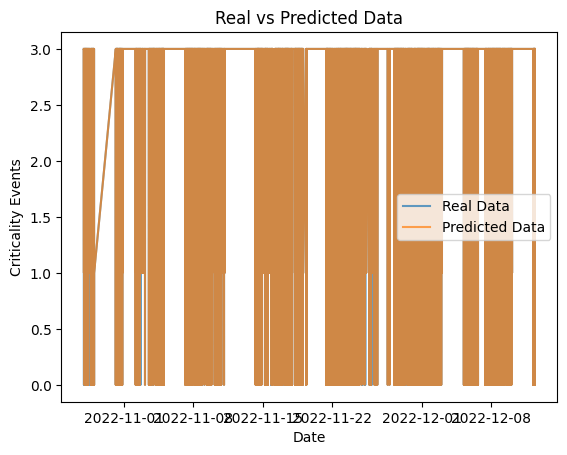

In [33]:
# Plot the real data (y_test)
plt.plot(y_test.index, y_test, label='Real Data', alpha=0.7)

# Plot the predicted data (y_pred)
plt.plot(y_test.index, y_pred, label='Predicted Data', alpha=0.7)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Criticality Events')
plt.title('Real vs Predicted Data')
plt.legend()

# Show the plot
plt.show()

In [41]:
unique_dates = y_test.index.unique()
print(unique_dates)


DatetimeIndex(['2022-10-27 23:58:34.394000', '2022-10-27 23:58:44.406000',
               '2022-10-27 23:58:54.417000', '2022-10-27 23:59:04.426000',
               '2022-10-27 23:59:14.436000', '2022-10-27 23:59:24.462000',
               '2022-10-27 23:59:34.481000', '2022-10-27 23:59:44.489000',
               '2022-10-27 23:59:54.509000', '2022-10-28 00:00:04.551000',
               ...
               '2022-12-12 08:20:07.769000', '2022-12-12 08:20:17.777000',
               '2022-12-12 08:20:27.795000', '2022-12-12 08:20:37.813000',
               '2022-12-12 08:20:47.870000', '2022-12-12 08:20:57.846000',
               '2022-12-12 08:21:08.067000', '2022-12-12 08:21:18.076000',
               '2022-12-12 08:21:28.092000', '2022-12-12 08:21:38.102000'],
              dtype='datetime64[ns]', name='created_at', length=232801, freq=None)


In [42]:
# Sort unique_dates in descending order
unique_dates_sorted = unique_dates.sort_values(ascending=False)

# Select the three most recent dates spaced by 1 day
recent_dates = unique_dates_sorted[:3:1]

# Set the true values for the selected dates
for date in recent_dates:
    partial_df.loc[date, 'true'] = y_test.loc[date]

In [43]:
# Identify the rows with missing values
missing_rows = partial_df['true'].isna()

# Predict the missing values using the model
partial_df.loc[missing_rows, 'predicted'] = model.predict(X_test.loc[missing_rows])

# Round the predicted values to the nearest integer
partial_df['predicted'] = partial_df['predicted'].round().astype(int)


ValueError: Expected a 1D array, got an array with shape (709256, 4)